# Import data and libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preproc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import GridSearchCV


from imblearn.over_sampling import SMOTE

import scripts

# constants and settings
rand_seed = 35

2025-12-03 10:17:55.793416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data
tree_data = pd.read_csv('../data/covtype.data', header=None)
tree_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_To_Hydrology',
             'Vertical_To_Hydrology', 'Horizontal_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
             'Horizontal_To_Fire'] + \
            [f'Wilderness_Area_{i}' for i in range(4)] + \
            [f'Soil_Type_{i}' for i in range(40)] + \
            ['Cover_Type']

# print(tree_data.describe())

In [3]:
tree_data.columns = tree_cols
print("Nan values in dataset:", tree_data.isna().sum().sum())
print(f"Dataset shape: {tree_data.shape}")

Nan values in dataset: 0
Dataset shape: (581012, 55)


# Data exploration

In [5]:
tree_reduced = scripts.sample_stratify(tree_data, 'Cover_Type', n_samples=2000, rand_state=rand_seed)
X_tree, y_tree = tree_reduced.drop(columns=['Cover_Type']), tree_reduced['Cover_Type']


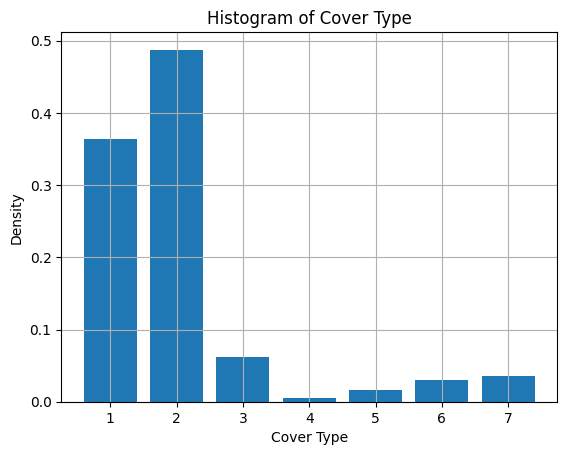

In [6]:
scripts.plot_histogram(y_tree, label='Cover Type')

Very uneven label distribution, mostly centered on types 1 and 2.
Stratified sampling require to ensure labels 3-7 are properly represented in training.

In [16]:
# std_scaler, x_st_scale = scripts.normalize_data(X_tree, method='standard')
scaler = preproc.StandardScaler()
x_st_scale = scaler.fit_transform(X_tree)

## Split training/testing data

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_st_scale, y_tree, test_size=0.2, stratify=y_tree, random_state=rand_seed)


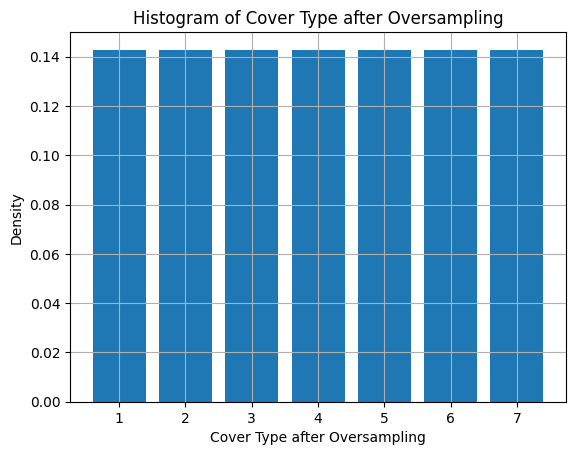

In [ ]:
# Oversample
x_resampled, y_resampled = SMOTE(random_state=rand_seed, sampling_strategy="auto", k_neighbors=2).fit_resample(x_train, y_train)
x_train, x_val, y_train, y_val = train_test_split(x_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=rand_seed)

scripts.plot_histogram(y_resampled, label='Cover Type after Oversampling')

# Model Creation

In [6]:
training_data, validation_data, test_data = scripts.load_processed_data('../data', prefix='one_under')
training_data = pd.concat([training_data, validation_data])
x_train, y_train = training_data.drop(columns=['Cover_Type']), training_data['Cover_Type']
x_test, y_test = test_data.drop(columns=['Cover_Type']), test_data['Cover_Type']

In [ ]:
knn_cv = GridSearchCV(KNeighborsClassifier(),
                      {'n_neighbors': [1, 3, 5, 7, 9], 'metric': ['cosine']},
                      cv=5, n_jobs=8,
                      scoring='accuracy')
knn_cv.fit(x_train, y_train, verbose=2)
print("Best K:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)

In [ ]:
knn_results = pd.DataFrame(knn_cv.cv_results_)
print("All cross-validation results:")
for row in knn_results.itertuples():
    print(f"k={row.params['n_neighbors']}, mean accuracy={row.mean_test_score:.4f}, \u03C3={row.std_test_score:.4f}")

All cross-validation results:
k=1, mean accuracy=0.8991, σ=0.0005
k=3, mean accuracy=0.8885, σ=0.0013
k=5, mean accuracy=0.8796, σ=0.0016
k=7, mean accuracy=0.8715, σ=0.0019
k=9, mean accuracy=0.8643, σ=0.0015


In [8]:
best_model = KNeighborsClassifier(n_neighbors=1, metric='cosine')
best_model.fit(x_train, y_train)
scripts.save_model(best_model, '../resources/models', 'knn')


# Evaluation

In [ ]:
y_pred = best_model.predict(x_test)
cmd, mcList, class_report, mcc = scripts.evaluate(y_test, y_pred)
print(f"Best number neighbors: {knn_cv.best_params_['n_neighbors']}")
cmd.plot()
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print("Classification Report:\n", class_report)